# Análisis de Series Temporales - Trabajo Práctico 2

Integrantes:
* Bermejo, Joaquín
* Scarafía, Franco
* Seward, Gerardrard

## 1. Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from neuralprophet import NeuralProphet

from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## 2. Carga de datasets

In [20]:
df = pd.read_csv('input/viajes_bici.csv')

df_train = df[df['fecha'] < '2024-01-01']
df_test  = df[df['fecha'] >= '2024-01-01']

In [21]:
eco = df[df['destino'] == 'Fac. Ciencias Económicas']
eco = eco.drop(['destino'], axis=1)

med = df[df['destino'] == 'Fac. Medicina']
med = med.drop(['destino'], axis=1)

ing = df[df['destino'] == 'Fac. de Ingeniería']
ing = ing.drop(['destino'], axis=1)

In [19]:
# Esto de momento no se usa

df_wide = eco.merge(med, on='fecha')
df_wide = df_wide.merge(ing, on='fecha')
df_wide = df_wide.rename(columns={"viajes_x": "eco", "viajes_y": "med", "viajes": "ing"})

In [22]:
eco_train = df_train[df_train['destino'] == 'Fac. Ciencias Económicas']
eco_test  = df_test[df_test['destino'] == 'Fac. Ciencias Económicas']

med_train = df_train[df_train['destino'] == 'Fac. Medicina']
med_test  = df_test[df_test['destino'] == 'Fac. Medicina']

ing_train = df_train[df_train['destino'] == 'Fac. de Ingeniería']
ing_test  = df_test[df_test['destino'] == 'Fac. de Ingeniería']

In [23]:
eco_train = eco_train.drop(['destino'], axis=1)
eco_train = eco_train.rename(columns={"fecha": "ds", "viajes": "y"})

eco_test = eco_test.drop(['destino'], axis=1)
eco_test = eco_test.rename(columns={"fecha": "ds", "viajes": "y"})

med_train = med_train.drop(['destino'], axis=1)
med_train = med_train.rename(columns={"fecha": "ds", "viajes": "y"})

med_test = med_test.drop(['destino'], axis=1)
med_test = med_test.rename(columns={"fecha": "ds", "viajes": "y"})

ing_train = ing_train.drop(['destino'], axis=1)
ing_train = ing_train.rename(columns={"fecha": "ds", "viajes": "y"})

ing_test = ing_test.drop(['destino'], axis=1)
ing_test = ing_test.rename(columns={"fecha": "ds", "viajes": "y"})

## 3. Ajuste de modelos

### 3a. Prophet

In [26]:
# Se inicializa y entrena el modelo
# Se define el intervalo de confianza en 95% (el valor por default es 80%)
prophet_eco = Prophet(interval_width=0.95)
prophet_eco.fit(eco_train)

10:43:47 - cmdstanpy - INFO - Chain [1] start processing
10:43:47 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future_eco = prophet_eco.make_future_dataframe(periods=121, freq='d')

In [32]:
# Se generan las predicciones
forecast_eco = prophet_eco.predict(future_eco)
forecast_eco[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1211,2024-04-26,78.787700,34.663730,121.367137
1212,2024-04-27,47.422835,1.138331,93.779444
1213,2024-04-28,48.091931,-5.235970,94.857801
1214,2024-04-29,82.328663,39.232067,128.740688
1215,2024-04-30,89.779453,44.922541,135.358951


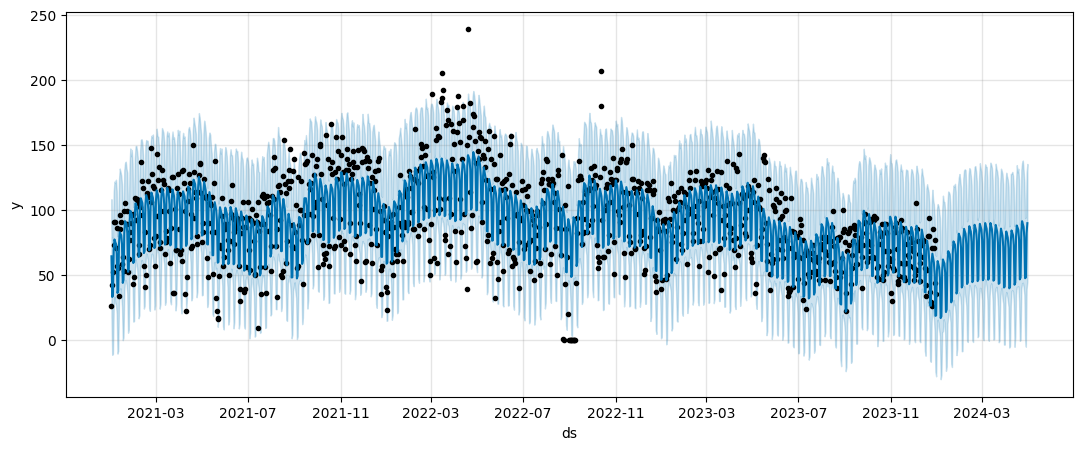

In [33]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = prophet_eco.plot(forecast_eco,ax=ax)
plt.show()

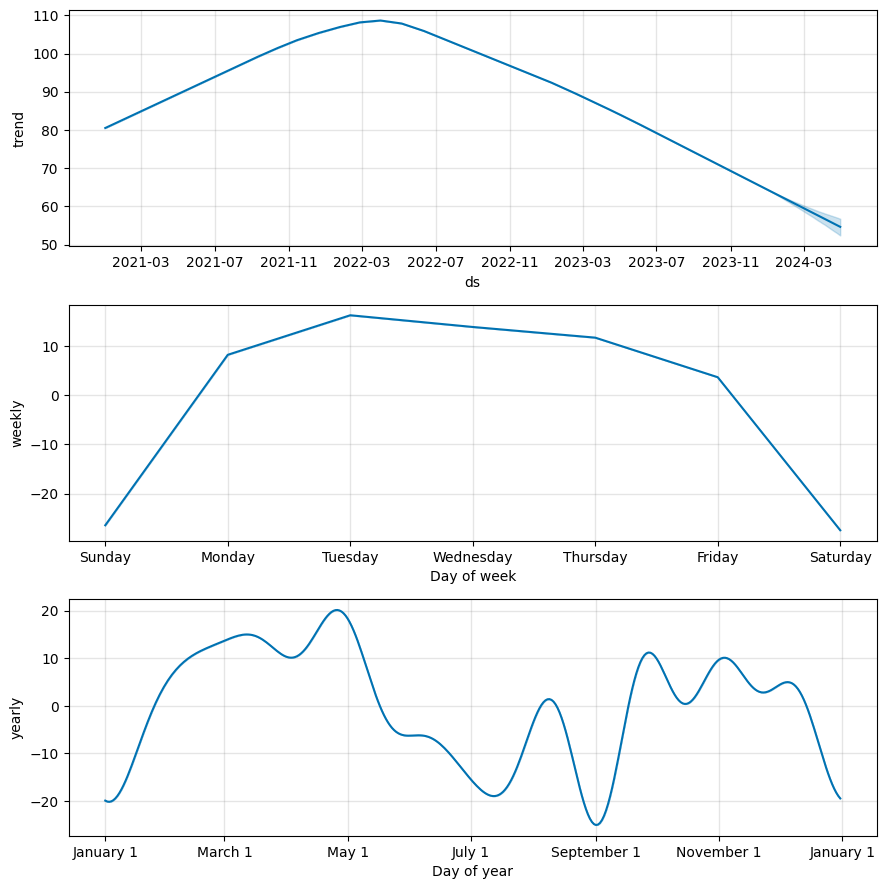

In [34]:
# Se grafican las componenestes de las predicciones
fig2 = prophet_eco.plot_components(forecast_eco)

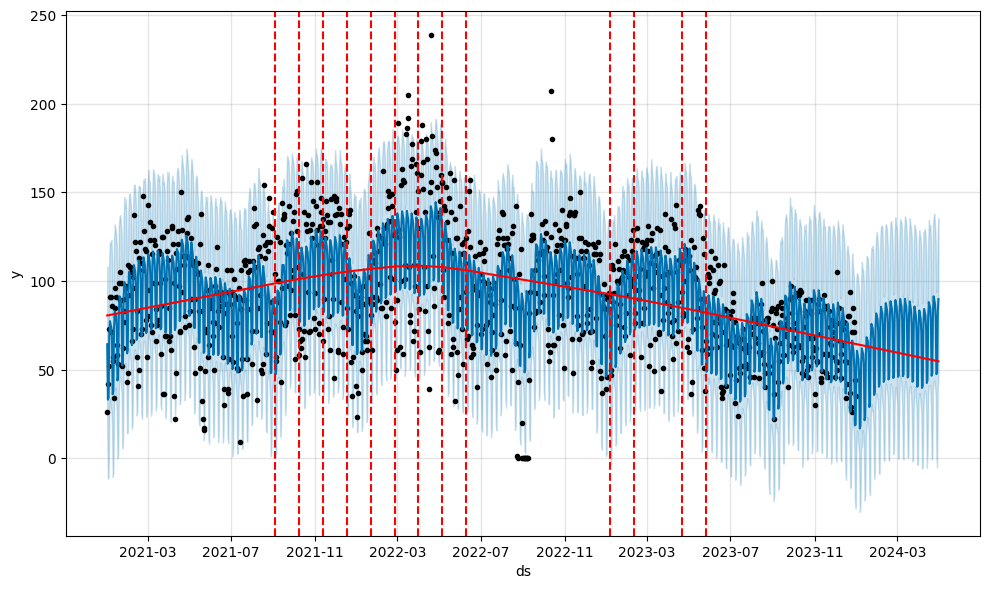

In [35]:
# Se grafican los puntos de cambio
fig = prophet_eco.plot(forecast_eco)
a = add_changepoints_to_plot(fig.gca(), prophet_eco, forecast_eco)

In [36]:
# Se generan las predicciones para la base de testeo
X_eco_forecast = prophet_eco.predict(eco_test)
X_eco_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-04-26,78.787700,28.093590,123.585014
117,2024-04-27,47.422835,0.851404,92.491051
118,2024-04-28,48.091931,2.469086,97.022218
119,2024-04-29,82.328663,35.496390,132.193293
120,2024-04-30,89.779453,42.524218,135.425813


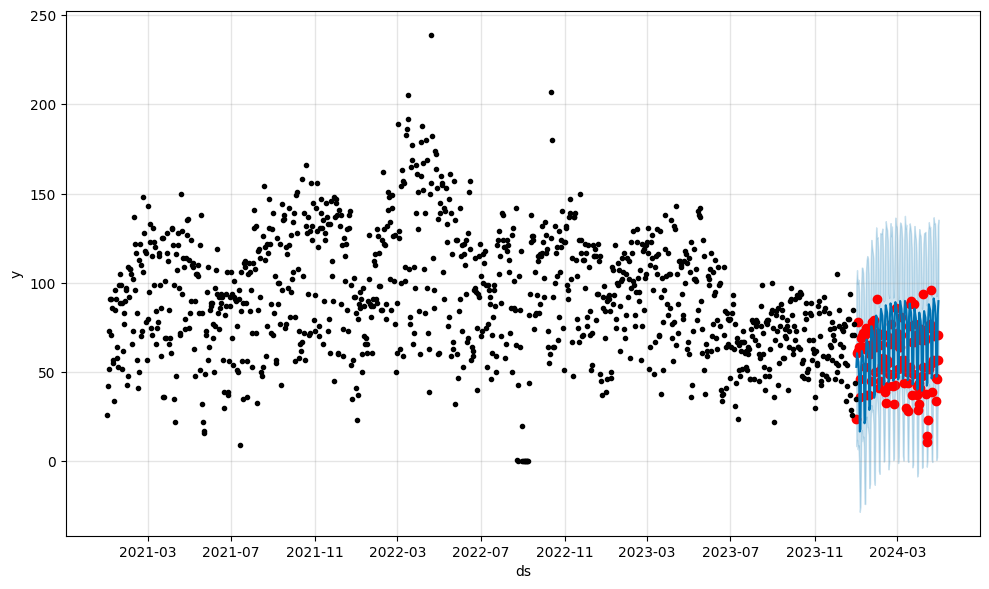

In [37]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
prophet_eco.plot(X_eco_forecast)
plt.scatter(eco_test.ds, eco_test['y'], color='r')

In [38]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(eco_test['y'], X_eco_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(eco_test['y'], X_eco_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 21.951
Test MSE: 481.867
Test MAE: 17.630
Test R2: -0.679


Peor que SARIMA. No le gana al naive estacional.

Ponele que como algo positivo podríamos decir que sirve para estudiar mejor el comportamiento de la serie (descriptivo, no inferencial) porque la desglosa en sus múltiples estacionalidades: semanal y anual.

Por ejemplo: se ve cómo los días de mayor actividad son los días de semana dentro del ciclo lectivo (decae sábados y domingos pero también en enero y julio).

In [66]:
# Habilitar la estacionalidad semanal, diaria y anual
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(eco_train)

10:10:30 - cmdstanpy - INFO - Chain [1] start processing
10:10:30 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future = m.make_future_dataframe(periods=121, freq='d')

In [68]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1211,2024-04-26,78.787700,30.585972,126.343399
1212,2024-04-27,47.422835,0.602896,92.140784
1213,2024-04-28,48.091931,0.218973,95.538949
1214,2024-04-29,82.328663,37.924056,126.790210
1215,2024-04-30,89.779453,41.351917,135.209714


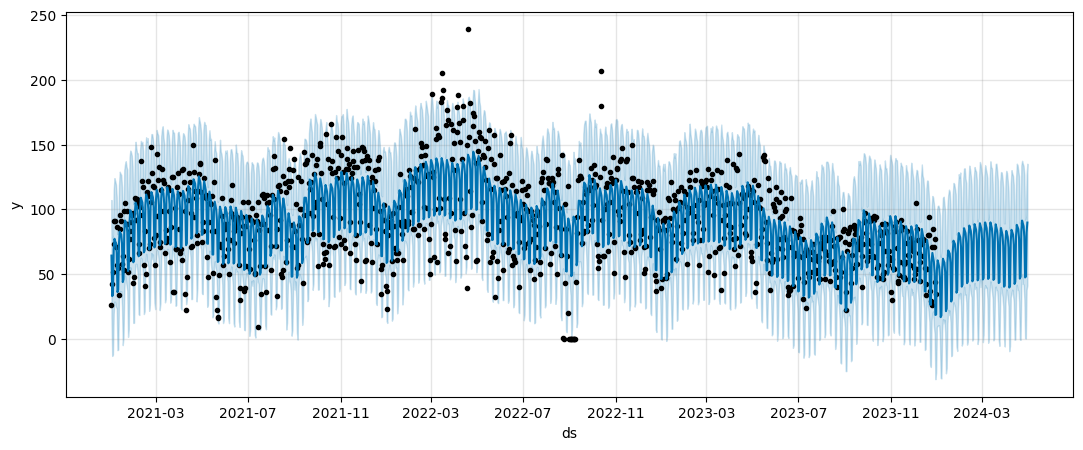

In [69]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

In [70]:
# Se generan las predicciones para la base de testeo
X_eco_forecast = m.predict(eco_test)
X_eco_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-04-26,78.787700,32.104309,123.029897
117,2024-04-27,47.422835,2.872674,96.118069
118,2024-04-28,48.091931,3.195496,96.005909
119,2024-04-29,82.328663,35.914646,126.260600
120,2024-04-30,89.779453,43.501590,132.530831


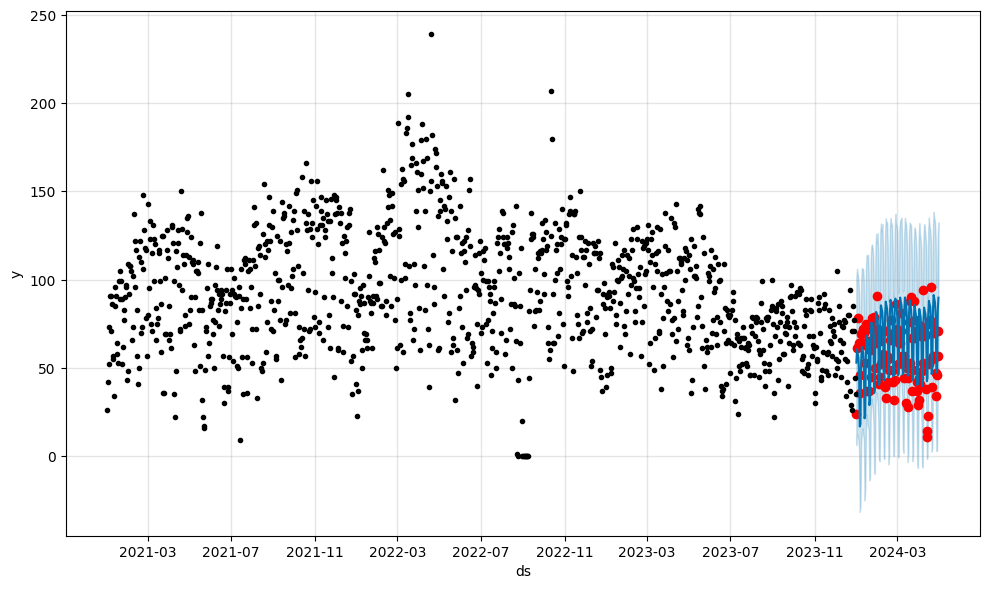

In [71]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
m.plot(X_eco_forecast)
plt.scatter(eco_test.ds, eco_test['y'], color='r')

In [73]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(eco_test['y'], X_eco_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(eco_test['y'], X_eco_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 21.951
Test MSE: 481.867
Test MAE: 17.630
Test R2: -0.679


Resultados iguales al anterior.

In [74]:
# Dias feriados
dias_feriados = pd.DataFrame({
  'holiday': 'Mantenimiento',
  'ds': pd.to_datetime(['2022-04-19', '2022-10-12', '2022-10-13'])
})

In [76]:
m = Prophet(interval_width=0.95,holidays=dias_feriados)
m.fit(eco_train)

10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:19 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
# Se generan las predicciones para la base de testeo
X_eco_forecast = m.predict(eco_test)
X_eco_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-04-26,78.643612,36.207902,121.564300
117,2024-04-27,47.416538,2.619196,92.968661
118,2024-04-28,48.226433,-0.725126,92.336902
119,2024-04-29,82.606039,40.200067,124.194288
120,2024-04-30,89.624657,46.176657,135.879164


In [78]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(eco_test['y'], X_eco_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(eco_test['y'], X_eco_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 21.949
Test MSE: 481.746
Test MAE: 17.594
Test R2: -0.679


La mejora es insignificante.

Probamos ahora para las otras dos series.

In [49]:
# Se define el modelo
prophet_med = Prophet(interval_width=0.95)
prophet_med.fit(med_train)

# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future_med = prophet_med.make_future_dataframe(periods=121, freq='d')

# Se generan las predicciones
forecast_med = prophet_med.predict(future_med)

# Se generan las predicciones para la base de testeo
X_med_forecast = prophet_med.predict(med_test)

10:54:23 - cmdstanpy - INFO - Chain [1] start processing
10:54:23 - cmdstanpy - INFO - Chain [1] done processing


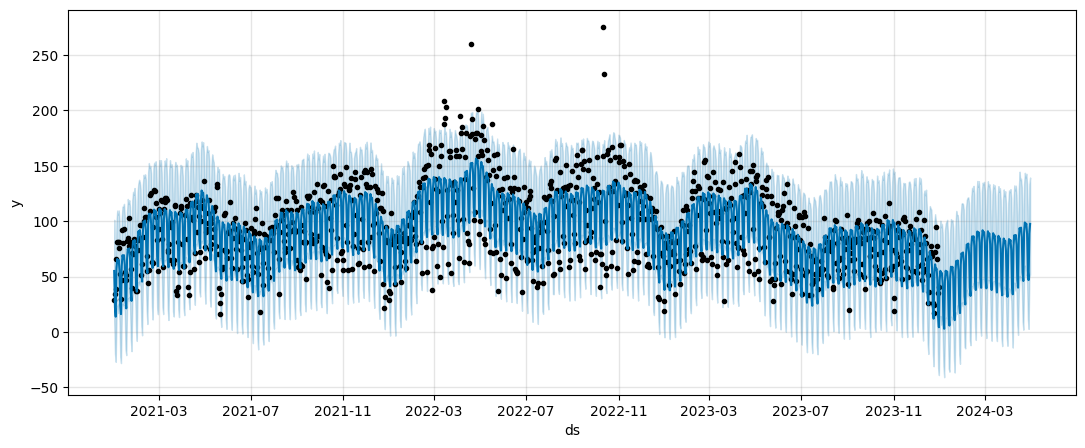

In [41]:
# Predicciones (línea) y base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = prophet_med.plot(forecast_med,ax=ax)
plt.show()

In [50]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(med_test['y'], X_med_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(med_test['y'], X_med_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(med_test['y'], X_med_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(med_test['y'], X_med_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test MSE: 513.349
Test MAE: 18.772
Test RMSE: 22.657
Test R2: -0.014


Peor que el SARIMA.

In [51]:
# Se define el modelo
prophet_ing = Prophet(interval_width=0.95)
prophet_ing.fit(ing_train)

# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future_ing = prophet_ing.make_future_dataframe(periods=121, freq='d')

# Se generan las predicciones
forecast_ing = prophet_ing.predict(future_ing)

# Se generan las predicciones para la base de testeo
X_ing_forecast = prophet_ing.predict(ing_test)

10:55:55 - cmdstanpy - INFO - Chain [1] start processing
10:55:55 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(ing_test['y'], X_ing_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ing_test['y'], X_ing_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(ing_test['y'], X_ing_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(ing_test['y'], X_ing_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test MSE: 425.686
Test MAE: 17.292
Test RMSE: 20.632
Test R2: -0.212


Tampoco le gana a SARIMA.